In [37]:
from pathlib import Path
import sys

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage

# Create output directories
from scipy.ndimage import median_filter
from scipy.signal import savgol_filter

# Compute silhouette scores
import xarray as xr

sys.path.append("../")
from src.readers.geom_reader import load_geodata
from src.utils.logger import setup_logger

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
log = setup_logger("chapter_one", log_file="../logs/chapter_one.log")

ws, gauges = load_geodata(folder_depth="../")
# Ensure indices are strings for consistent joins
gauges.index = gauges.index.map(str)
ws.index = ws.index.map(str)

basemap_data = gpd.read_file("../data/geometry/basemap_2023.gpkg")
# Placeholder; will be recomputed after loading attribute tables
common_index = gauges.index.to_list()


In [38]:
def_dir = Path("../res/chapter_one")
img_dir = def_dir / "hybrid_analysis" / "images"
img_dir.mkdir(parents=True, exist_ok=True)
table_dir = def_dir / "hybrid_analysis" / "tables"
table_dir.mkdir(parents=True, exist_ok=True)


### Geo cluster

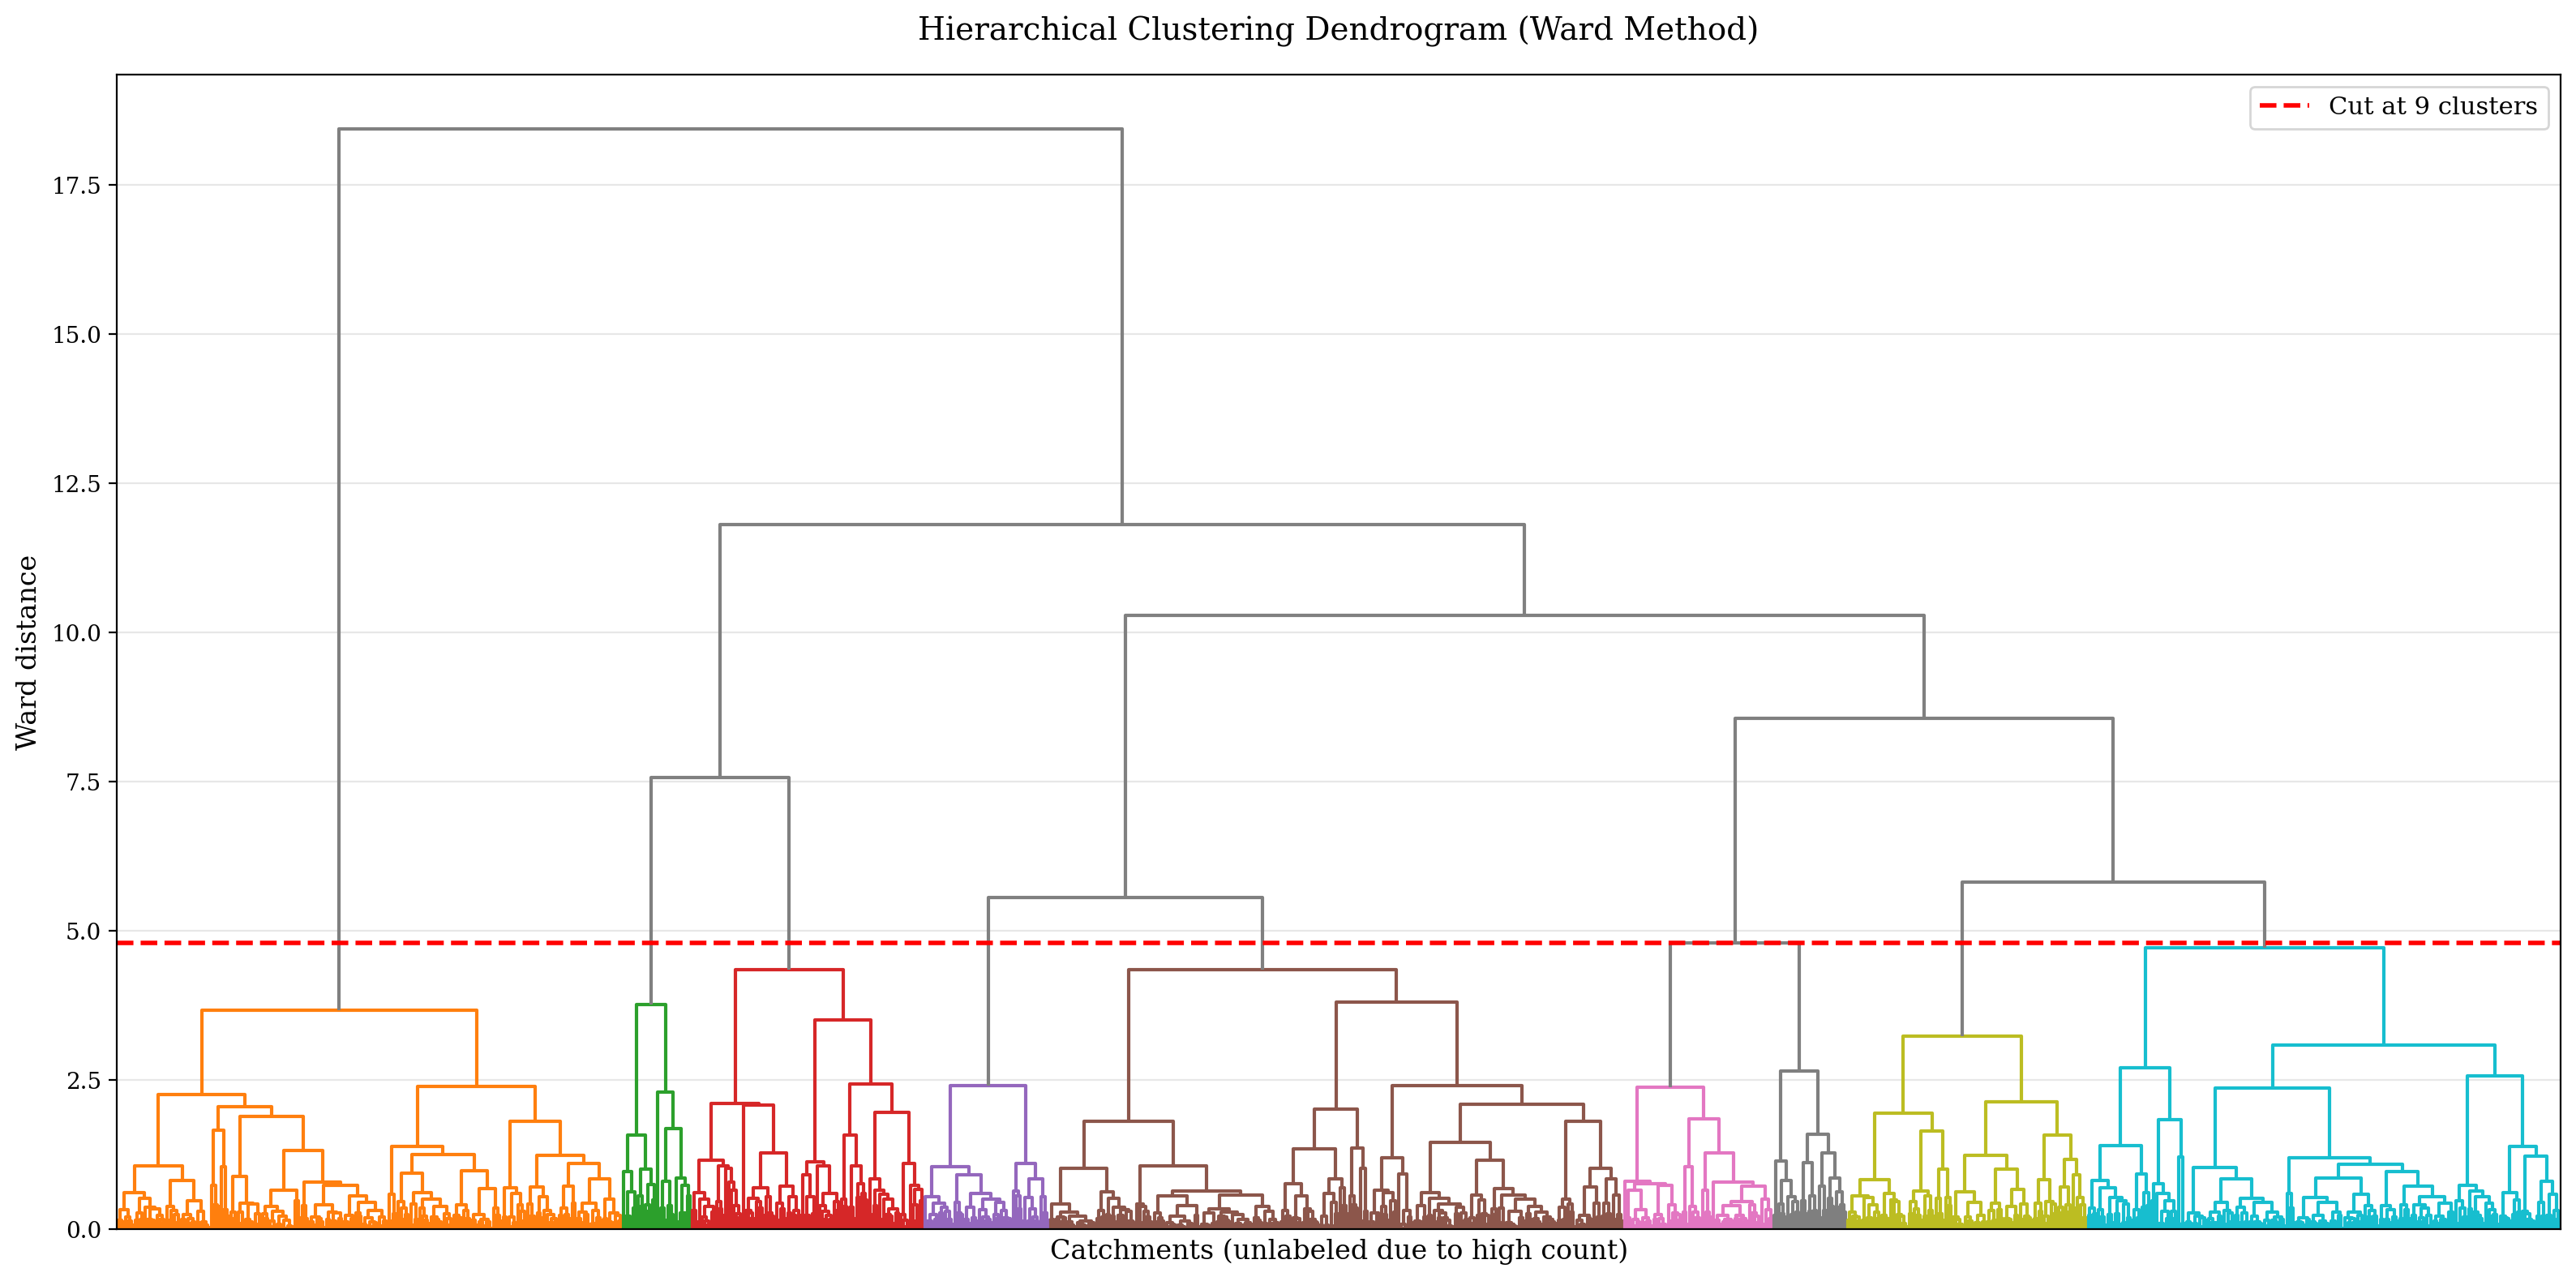

In [39]:
# Load HydroATLAS data (robust to indexing mismatches)
geo_data = pd.read_csv(
    "../data/attributes/hydro_atlas_cis_camels.csv",
    dtype={"gauge_id": str},
)

# Ensure gauge_id is the index if present
if "gauge_id" in geo_data.columns:
    geo_data = geo_data.set_index("gauge_id")

# Sanity: coerce to string index
go_idx_before = geo_data.index
geo_data.index = geo_data.index.map(str)

# Ensure upstream geodataframes also use string indices (done earlier, but safe)
gauges = gauges.copy()
ws = ws.copy()
gauges.index = gauges.index.map(str)
ws.index = ws.index.map(str)

# Select static parameters
static_parameters = [
    "for_pc_use",
    "crp_pc_use",
    "inu_pc_ult",
    "ire_pc_use",
    "lka_pc_use",
    "prm_pc_use",
    "pst_pc_use",
    "cly_pc_uav",
    "slt_pc_uav",
    "snd_pc_uav",
    "kar_pc_use",
    "urb_pc_use",
    "gwt_cm_sav",
    "lkv_mc_usu",
    "rev_mc_usu",
    "slp_dg_uav",
    "sgr_dk_sav",
    "ws_area",
    "ele_mt_uav",
]

# Intersect indices to avoid KeyError on selection
available = pd.Index(gauges.index).intersection(geo_data.index)
missing_from_geo = len(gauges.index) - len(available)
if missing_from_geo:
    print(
        f"Warning: {missing_from_geo} gauges missing in HydroATLAS table; they will be dropped."
    )

# Filter geodata to available gauges for consistency across the notebook
gauges = gauges.loc[available].copy()
ws = ws.loc[available].copy()
common_index = gauges.index.to_list()

# Now safely subset static attributes
missing_cols = [c for c in static_parameters if c not in geo_data.columns]
if missing_cols:
    raise KeyError(
        f"Columns missing in HydroATLAS CSV: {missing_cols}. Available: {list(geo_data.columns)[:10]}..."
    )

go_subset = geo_data.loc[common_index, static_parameters]

# Scale to 0-1 range
geo_scaled = (go_subset - go_subset.min()) / (go_subset.max() - go_subset.min())

available_features = geo_scaled.loc[:, static_parameters].columns
cluster_number = 9
# Compute linkage matrix
Z = linkage(geo_scaled.values, method="ward", metric="euclidean")

# Plot dendrogram (without x-axis labels due to many gauges)
fig, ax = plt.subplots(figsize=(16, 8))
dendro = dendrogram(
    Z,
    ax=ax,
    above_threshold_color="#808080",
    color_threshold=Z[-cluster_number + 1, 2],
    no_labels=True,  # Don't show gauge IDs on x-axis
)

ax.set_xlabel("Catchments (unlabeled due to high count)", fontsize=12)
ax.set_ylabel("Ward distance", fontsize=12)
ax.set_title("Hierarchical Clustering Dendrogram (Ward Method)", fontsize=14, pad=15)
ax.axhline(
    y=Z[-cluster_number + 1, 2],
    color="r",
    linestyle="--",
    linewidth=2,
    label=f"Cut at {cluster_number} clusters",
)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

geo_labels = fcluster(Z, t=cluster_number, criterion="maxclust")


### Hydro cluster

Applied spike removal and smoothing to 996 gauges
Smoothing: median filter (spike detection) + Savitzky-Golay (curve flattening)

Prepared seasonal patterns for 996 gauges
Features per gauge: 368 (366 days + 2 coords)
Normalized discharge range: [0.00, 1.00]


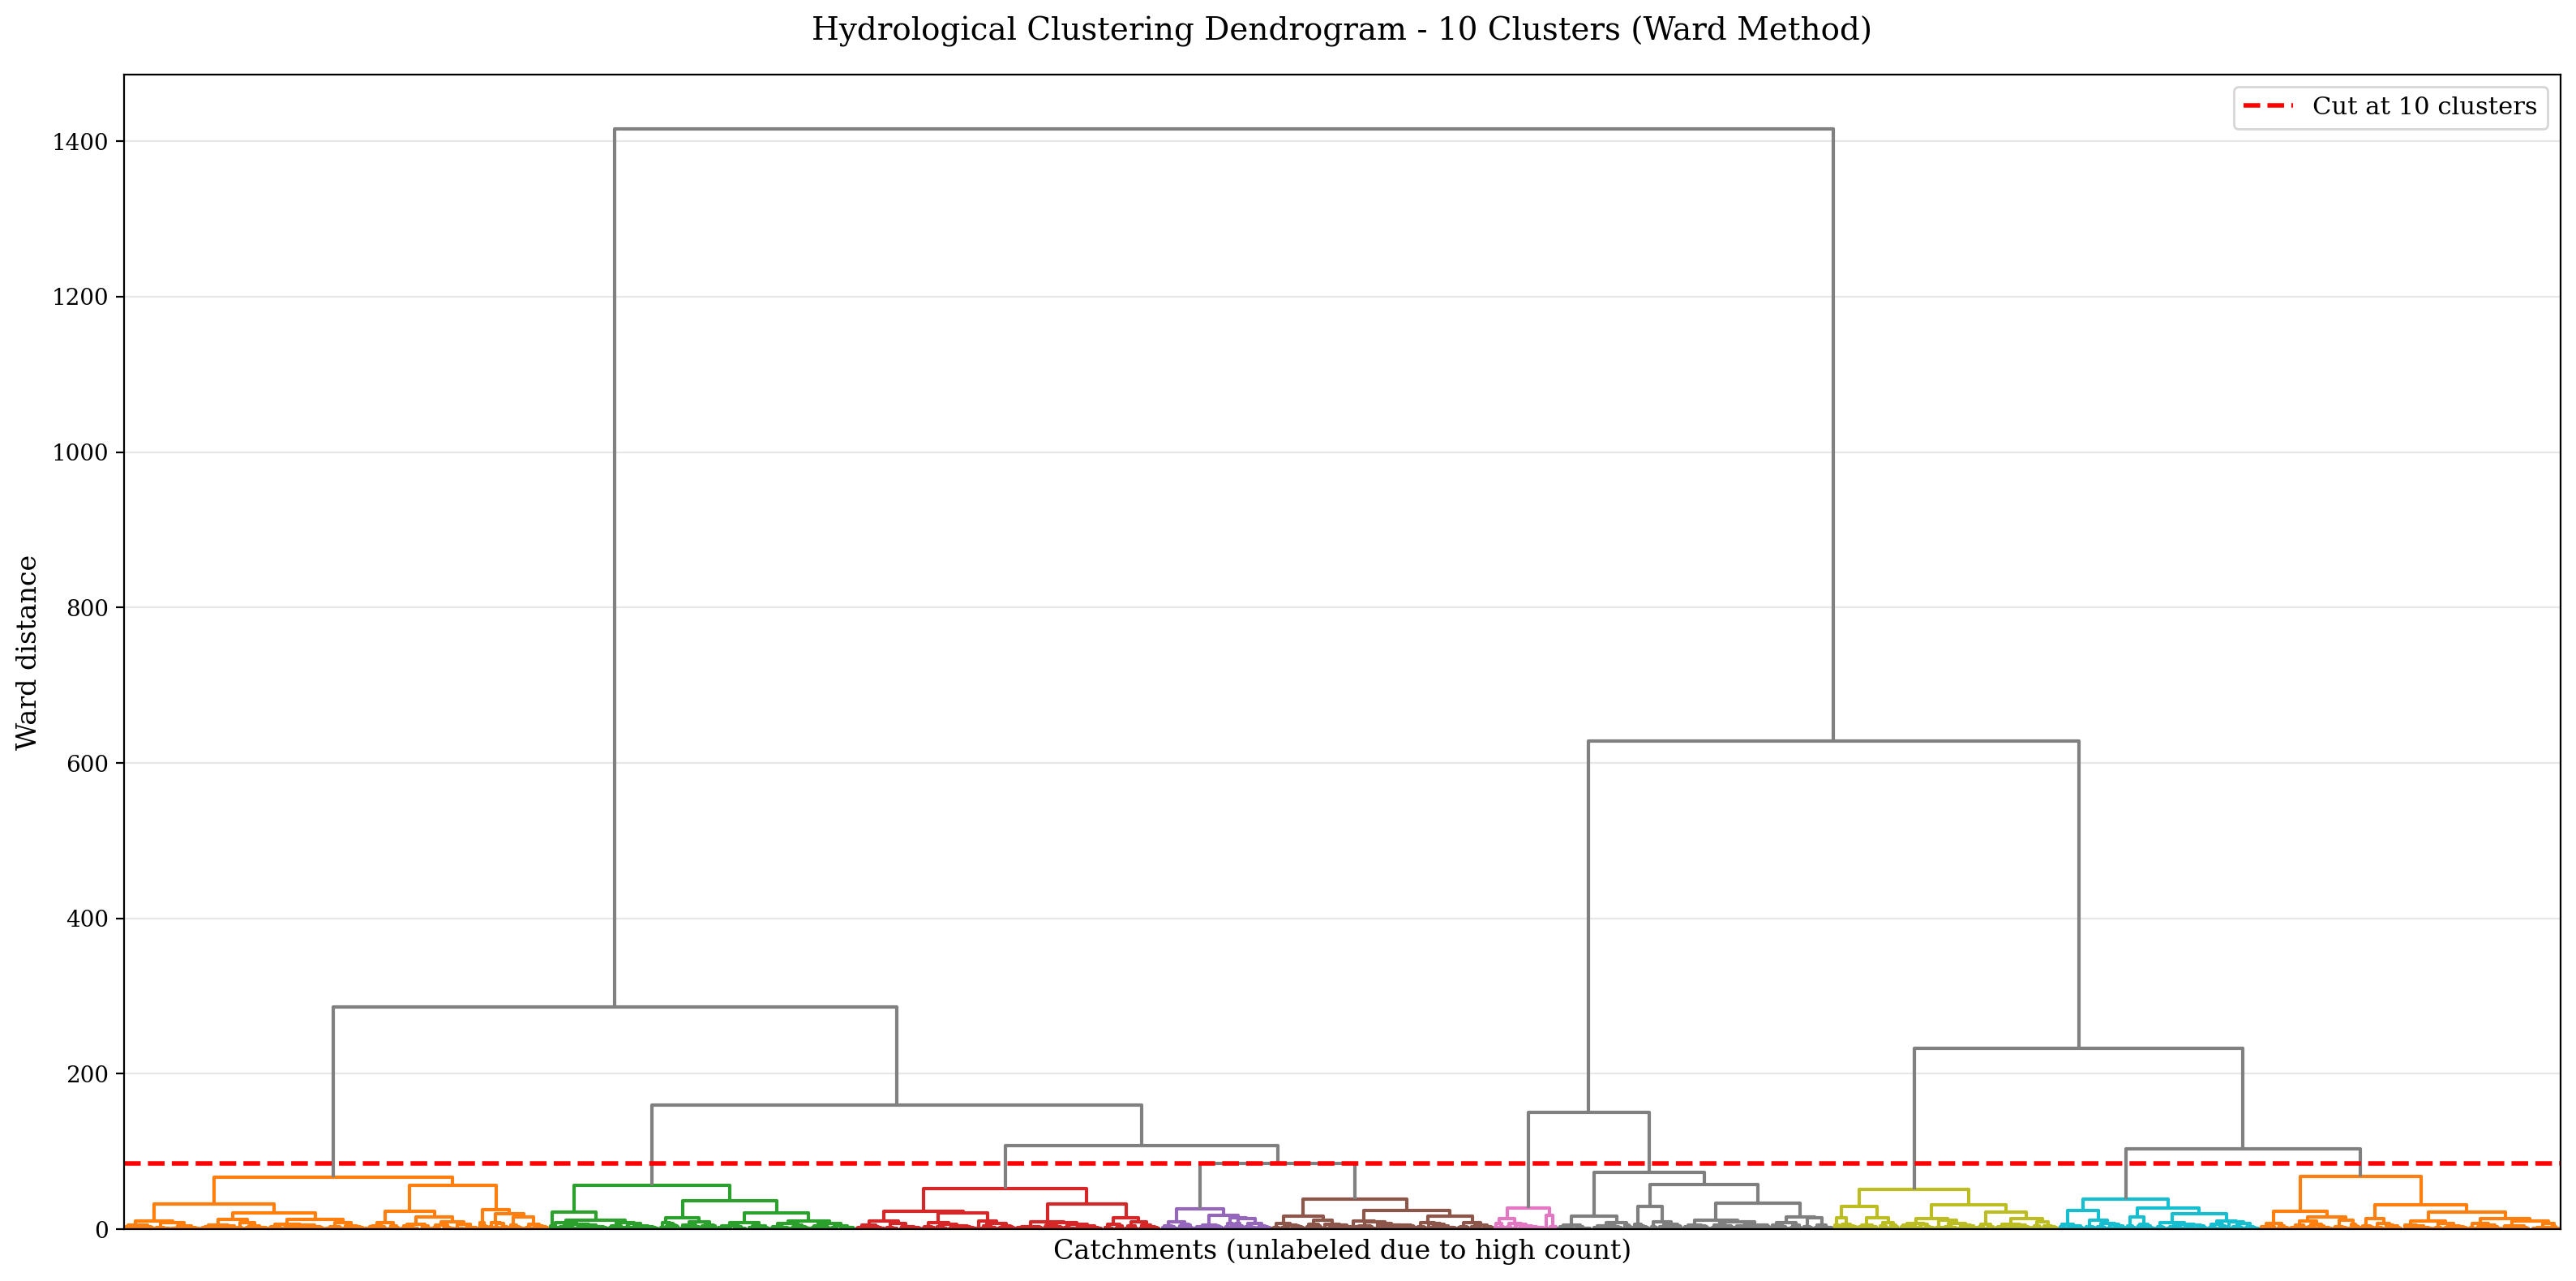

2025-11-11 00:35:50 | INFO     | PhDLogger | chapter_one | ℹ️  Hierarchical clustering complete: 10 clusters


In [41]:
# Load discharge time series for all gauges
discharge_data = {}
dis_column = "q_mm_day"

for gauge_id in ws.index:
    try:
        with xr.open_dataset(f"../data/nc_all_q/{gauge_id}.nc") as ds:
            df = ds.to_dataframe()
        discharge_data[gauge_id] = df[[dis_column]].squeeze()

    except Exception as e:
        log.error(f"Error loading discharge for {gauge_id}: {e}")
        continue

# Calculate median seasonal cycle for each gauge
q_df = {}

for gauge_id in discharge_data.keys():
    try:
        ts = discharge_data[gauge_id]
        # Group by day of year and take median across all years
        seasonal_cycle = ts.groupby([ts.index.month, ts.index.day]).median().values
        q_df[gauge_id] = seasonal_cycle

    except Exception as e:
        log.error(f"Error calculating seasonal cycle for {gauge_id}: {e}")
        continue

# Convert to DataFrame (rows=days, columns=gauges)
q_df = pd.DataFrame.from_dict(q_df, orient="columns")

# Filter out gauges with extreme outliers (max > 50 mm/day)
q_df = q_df.loc[:, q_df.max() < 50]

# ===== SPIKE DETECTION AND SMOOTHING =====
# Detect and interpolate anomalous spikes (likely data artifacts)


q_df_smoothed = q_df.copy()

for col in q_df_smoothed.columns:
    series = q_df_smoothed[col].values

    # Apply median filter to detect outliers (window=5 days)
    smoothed = median_filter(series, size=5, mode="wrap")

    # Calculate residuals
    residuals = np.abs(series - smoothed)
    threshold = residuals.std() * 3  # 3-sigma threshold

    # Identify spikes
    spike_mask = residuals > threshold

    if spike_mask.any():
        # Interpolate spikes using linear interpolation
        valid_indices = np.where(~spike_mask)[0]
        spike_indices = np.where(spike_mask)[0]

        if len(valid_indices) > 1:
            # Linear interpolation of spike values
            interpolated_values = np.interp(
                spike_indices, valid_indices, series[valid_indices]
            )
            series[spike_indices] = interpolated_values

    # Savitzky-Golay: window=11 days, polynomial order=3
    # This preserves peaks but removes high-frequency noise
    series_smoothed = savgol_filter(series, window_length=11, polyorder=3, mode="wrap")

    q_df_smoothed[col] = series_smoothed

# Replace original with smoothed
q_df = q_df_smoothed.copy()

print(f"Applied spike removal and smoothing to {len(q_df.columns)} gauges")
print("Smoothing: median filter (spike detection) + Savitzky-Golay (curve flattening)")

# Normalize each gauge's pattern to [0, 1]
q_df_normalized = q_df.copy()
q_df_normalized = (q_df_normalized - q_df_normalized.min()) / (
    q_df_normalized.max() - q_df_normalized.min()
)

# Transpose for clustering (rows=gauges, columns=days)
q_df_clust = q_df_normalized.copy().T

# Add spatial coordinates as features (optional: weight spatial proximity)
for gauge_id in q_df_clust.index:
    q_df_clust.loc[gauge_id, "lat"] = gauges.loc[gauge_id, "geometry"].y
    q_df_clust.loc[gauge_id, "lon"] = gauges.loc[gauge_id, "geometry"].x

# Remove any gauges with NaN values
q_df_clust = q_df_clust.dropna()
hydro_index = q_df_clust.index

discharge_data = {k: v for k, v in discharge_data.items() if k in hydro_index}
print(f"\nPrepared seasonal patterns for {len(q_df_clust)} gauges")
print(f"Features per gauge: {q_df_clust.shape[1]} (366 days + 2 coords)")
print(
    f"Normalized discharge range: [{q_df_normalized.min().min():.2f}, {q_df_normalized.max().max():.2f}]"
)
# Perform hierarchical clustering using Ward's method
n_hydro_clusters = 10

Z = linkage(q_df_clust.values, method="ward", metric="euclidean")

# Create dendrogram
fig, ax = plt.subplots(figsize=(16, 8))
dendro = dendrogram(
    Z,
    ax=ax,
    above_threshold_color="#808080",
    color_threshold=Z[-n_hydro_clusters + 1, 2],
    no_labels=True,
    truncate_mode="level",
    p=0,
)

ax.set_xlabel("Catchments (unlabeled due to high count)", fontsize=12)
ax.set_ylabel("Ward distance", fontsize=12)
ax.set_title(
    f"Hydrological Clustering Dendrogram - {n_hydro_clusters} Clusters (Ward Method)",
    fontsize=14,
    pad=15,
)
ax.axhline(
    y=Z[-n_hydro_clusters + 1, 2],
    color="r",
    linestyle="--",
    linewidth=2,
    label=f"Cut at {n_hydro_clusters} clusters",
)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

log.info(f"Hierarchical clustering complete: {n_hydro_clusters} clusters")
# Extract cluster labels using fcluster
hydro_labels = fcluster(Z, t=n_hydro_clusters, criterion="maxclust")


### Hybrid clustering

In [42]:
# Prepare cluster names for geographic visualization
gauge_clustered = gauges.copy()
# Use display names with "C{id}:" prefix so sorting works correctly
gauge_clustered["geo_cluster"] = [f"G{cl}" for cl in geo_labels]
gauge_clustered["hydro_cluster"] = [f"H{cl}" for cl in hydro_labels]


In [43]:
# Create hybrid combination labels (e.g., "G1-H2")
gauge_clustered["hybrid_combo"] = (
    gauge_clustered["geo_cluster"] + "-" + gauge_clustered["hydro_cluster"]
)

# Display distribution of combinations
combo_counts = gauge_clustered["hybrid_combo"].value_counts()
print(f"Total unique hybrid combinations: {len(combo_counts)}")
print(f"Gauges per combination (mean): {combo_counts.mean():.1f}")
print(f"Gauges per combination (median): {combo_counts.median():.0f}")
print("\nTop 10 most common combinations:")
print(combo_counts.head(10))

# Create a contingency table: geo_cluster × hydro_cluster
contingency = pd.crosstab(
    gauge_clustered["geo_cluster"],
    gauge_clustered["hydro_cluster"],
    margins=True,
    margins_name="Total",
)
print("\n=== Contingency Table: Geographic × Hydrological Clusters ===")
print(contingency)

# Save contingency table
contingency.to_csv(table_dir / "geo_hydro_contingency.csv")
log.info(f"Saved contingency table to {table_dir / 'geo_hydro_contingency.csv'}")

2025-11-11 00:35:59 | INFO     | PhDLogger | chapter_one | ℹ️  Saved contingency table to ../res/chapter_one/hybrid_analysis/tables/geo_hydro_contingency.csv


Total unique hybrid combinations: 51
Gauges per combination (mean): 19.5
Gauges per combination (median): 11

Top 10 most common combinations:
hybrid_combo
G1-H5    68
G5-H3    66
G9-H7    64
G1-H1    52
G1-H3    52
G4-H2    50
G3-H8    50
G9-H9    44
G8-H1    43
G5-H2    43
Name: count, dtype: int64

=== Contingency Table: Geographic × Hydrological Clusters ===
hydro_cluster   H1  H10   H2   H3  H4  H5  H6   H7  H8  H9  Total
geo_cluster                                                      
G1              52   17    3   52  11  68   0    0   0   3    206
G2               0    1    0    0  27   0   0    0   0   0     28
G3               3    9    0    0   0   0  22    8  50   3     95
G4               0    0   50    1   0   0   0    0   0   0     51
G5              39   37   43   66   0  14   4   25   0   6    234
G6               4    6   27    0   0   8   0   10   6   0     61
G7               0    2    0    0   0   0   0    2  15  11     30
G8              43   30    1    1   3   1

In [44]:
from src.analytics.cluster_hex_analysis import (
    aggregate_clusters_to_hex,
    map_secondary_cluster_to_hex,
)
from src.plots.hex_utils import build_hex_grid, to_equal_area

# Transform to equal-area projection (Albers Equal Area for Russia)
aea_crs = (
    "+proj=aea +lat_0=56 +lon_0=100 +lat_1=50 +lat_2=70 "
    "+x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
)

ws_aea = to_equal_area(ws, crs=aea_crs)
gauges_aea = to_equal_area(gauge_clustered, crs=aea_crs)

# Build hexagonal grid
# Target ~6 watersheds per hex for meaningful aggregation
from shapely.geometry import box

extent_poly = box(*ws_aea.total_bounds)
hex_grid = build_hex_grid(extent_poly, r_km=80, crs=aea_crs)

print(f"Created {len(hex_grid)} hexagons with radius ~80 km")
print(f"Total watersheds: {len(ws_aea)}")
print("Target density: ~6 watersheds per hex")

Created 1897 hexagons with radius ~80 km
Total watersheds: 996
Target density: ~6 watersheds per hex


In [45]:
# Aggregate watersheds to hexes using GEOGRAPHIC clusters (primary)
ws_with_geo = ws_aea.copy()
ws_with_geo["geo_cluster"] = gauge_clustered.loc[ws_aea.index, "geo_cluster"]

hexes_with_geo = aggregate_clusters_to_hex(
    watersheds=ws_with_geo,
    hexes=hex_grid,
    cluster_col="geo_cluster",
    method="dominant",
    min_watersheds=2,  # Require at least 2 watersheds per hex
)

print(f"Hexes with dominant geographic cluster: {len(hexes_with_geo)}")
print(f"Geographic clusters present: {hexes_with_geo['dominant_cluster'].unique()}")

# Map HYDROLOGICAL clusters (secondary) onto geo-clustered hexes
ws_with_hydro = ws_aea.copy()
ws_with_hydro["hydro_cluster"] = gauge_clustered.loc[ws_aea.index, "hydro_cluster"]

hexes_with_both = map_secondary_cluster_to_hex(
    watersheds=ws_with_hydro,
    hexes_with_primary=hexes_with_geo,
    primary_cluster_col="dominant_cluster",
    secondary_cluster_col="hydro_cluster",
    hex_id_col="hex_id",
)

print("\n=== Secondary (Hydro) Cluster Mapping ===")
print(f"Hexes with hydro info: {hexes_with_both['dominant_hydro_cluster'].notna().sum()}")
print(
    f"Mean hydro diversity per hex: {hexes_with_both['hydro_cluster_diversity'].mean():.2f}"
)

# Create final hybrid classification: combine dominant geo + dominant hydro
hexes_with_both["hybrid_combo"] = (
    hexes_with_both["dominant_cluster"].astype(str)
    + "-"
    + hexes_with_both["dominant_hydro_cluster"].astype(str)
)

combo_hex_counts = hexes_with_both["hybrid_combo"].value_counts()
print(f"\nUnique hex-level hybrid combinations: {len(combo_hex_counts)}")
print("\nTop 10 hex-level combinations:")
print(combo_hex_counts.head(10))

Hexes with dominant geographic cluster: 231
Geographic clusters present: ['G6' 'G9' 'G3' 'G8' 'G1' 'G7' 'G5' 'G2' 'G4']

=== Secondary (Hydro) Cluster Mapping ===
Hexes with hydro info: 231
Mean hydro diversity per hex: 0.03

Unique hex-level hybrid combinations: 37

Top 10 hex-level combinations:
hybrid_combo
G1-H3    19
G1-H5    17
G3-H8    15
G5-H3    15
G9-H7    13
G1-H1    11
G5-H1    11
G4-H2    10
G8-H1    10
G9-H9    10
Name: count, dtype: int64


In [51]:
from src.analytics.cluster_hex_analysis import (
    assign_gauges_to_hybrid_classes,
    consolidate_hybrid_combinations,
)

# Ensure hybrid combo exists on hex grid (robust to partial runs)
if "hybrid_combo" not in hexes_with_both.columns:
    if {"dominant_cluster", "dominant_hydro_cluster"}.issubset(hexes_with_both.columns):
        hexes_with_both["hybrid_combo"] = (
            hexes_with_both["dominant_cluster"].astype(str)
            + "-"
            + hexes_with_both["dominant_hydro_cluster"].astype(str)
        )
    else:
        raise KeyError(
            "hexes_with_both lacks 'hybrid_combo' and components; rerun previous cell."
        )

# Assign each gauge to a hybrid combination based on hex membership
gauges_with_combos = assign_gauges_to_hybrid_classes(
    gauges=gauges_aea,
    watersheds=ws_aea,
    hexes_with_combos=hexes_with_both,
    combo_col="hybrid_combo",
    hex_id_col="hex_id",
    k_neighbors=5,  # Blend singletons using 5 nearest hexes
)

# Debug: inspect result columns
print("gauges_with_combos columns:\n", list(gauges_with_combos.columns))
print("Contains 'hybrid_combo'?", "hybrid_combo" in gauges_with_combos.columns)

print(
    f"Gauges with hybrid combos assigned: {gauges_with_combos['hybrid_combo'].notna().sum()}"
)
print(
    f"Unique combinations before consolidation: {gauges_with_combos['hybrid_combo'].nunique()}"
)

# Consolidate into ~15 meaningful classes
gauges_final, mapping_df = consolidate_hybrid_combinations(
    gauges_with_combos=gauges_with_combos,
    combo_col="hybrid_combo",
    target_n_classes=15,
    min_gauges_per_class=5,
)

print("\n=== Final Hybrid Classification ===")
print(f"Final number of classes: {gauges_final['hybrid_class'].nunique()}")
print(
    f"Gauges per class (mean): {gauges_final['hybrid_class'].value_counts().mean():.1f}"
)
print("\nClass distribution:")
print(gauges_final["hybrid_class"].value_counts().sort_index())

# Save mapping table
mapping_df.to_csv(table_dir / "hybrid_class_mapping.csv", index=False)
log.info(f"Saved hybrid class mapping to {table_dir / 'hybrid_class_mapping.csv'}")

# Transfer back to original CRS
# Set index to gauge_clustered.index for correct alignment
gauges_final_wgs84 = gauges_final.to_crs(gauges.crs)
gauges_final_wgs84.index = gauge_clustered.index
print("Set gauges_final_wgs84 index to gauge_clustered index.")

# Drop hybrid_class from gauge_clustered if it exists, then join
if "hybrid_class" in gauge_clustered.columns:
    gauge_clustered = gauge_clustered.drop(columns=["hybrid_class"])
gauge_clustered = gauge_clustered.join(gauges_final_wgs84[["hybrid_class"]], how="left")
print(
    "Assigned 'hybrid_class' to gauge_clustered. Nulls:",
    gauge_clustered["hybrid_class"].isna().sum(),
)


2025-11-11 00:41:26 | INFO     | PhDLogger | chapter_one | ℹ️  Saved hybrid class mapping to ../res/chapter_one/hybrid_analysis/tables/hybrid_class_mapping.csv


gauges_with_combos columns:
 ['geometry', 'hex_id', 'hybrid_combo']
Contains 'hybrid_combo'? True
Gauges with hybrid combos assigned: 996
Unique combinations before consolidation: 37

=== Final Hybrid Classification ===
Final number of classes: 16
Gauges per class (mean): 62.2

Class distribution:
hybrid_class
G1-H1        46
G1-H3        66
G1-H5       110
G2-H4        33
G3-H8       115
G4-H2        54
G5-H1        51
G5-H10       40
G5-H2        41
G5-H3       100
G6-H2        62
G8-H1        75
G8-H10       40
G9-H7       105
G9-H9        43
Other-G7     15
Name: count, dtype: int64
Set gauges_final_wgs84 index to gauge_clustered index.
Assigned 'hybrid_class' to gauge_clustered. Nulls: 0


In [52]:
# Debug: inspect hexes_with_both columns just before assignment step
print("hexes_with_both columns:\n", list(hexes_with_both.columns))
print("Contains 'hybrid_combo'?", "hybrid_combo" in hexes_with_both.columns)
print(hexes_with_both[["dominant_cluster", "dominant_hydro_cluster"]].head())


hexes_with_both columns:
 ['hex_id', 'geometry', 'dominant_cluster', 'count', 'dominant_hydro_cluster', 'hydro_cluster_diversity', 'hydro_cluster_n_types', 'hybrid_combo']
Contains 'hybrid_combo'? True
  dominant_cluster dominant_hydro_cluster
0               G6                     H7
1               G9                     H7
2               G3                     H8
3               G9                     H8
4               G9                     H7


In [53]:
# Reload updated analytics module to ensure latest function definitions are used
import importlib

from src.analytics import cluster_hex_analysis as cha

importlib.reload(cha)
from src.analytics.cluster_hex_analysis import (
    assign_gauges_to_hybrid_classes,
    consolidate_hybrid_combinations,
)

print("Reloaded cluster_hex_analysis; functions re-imported.")

Reloaded cluster_hex_analysis; functions re-imported.


In [54]:
gauge_clustered


,name_ru,name_en,geometry,geo_cluster,hydro_cluster,hybrid_combo,hybrid_class
gauge_id,,,,,,,
70158,р.Кичменьга - д.Захарово,r.Kichmen'ga - d.Zaharovo,POINT (45.6336 60.05368),G5,H3,G5-H3,G5-H3
8290,р.Карабула - с.Карабула,r.Karabula - s.Karabula,POINT (97.38294 58.03246),G9,H9,G9-H9,G9-H9
70583,р.Уфтюга - с.Богородское,r.Uftjuga - s.Bogorodskoe,POINT (39.27252 59.99077),G5,H3,G5-H3,G5-H3
76408,р.Ай - г.Златоуст,r.Aj - g.Zlatoust,POINT (59.67519 55.17181),G9,H1,G9-H1,G8-H1
72668,р.Алоля - д.Ермолово,r.Alolja - d.Ermolovo,POINT (29.14565 56.50485),G5,H2,G5-H2,G5-H2
...,...,...,...,...,...,...,...
10584,р.Тисулька - пгт Тисуль,r.Tisul'ka - pgt Tisul',POINT (88.32491 55.7643),G8,H10,G8-H10,G8-H10
72577,р.Луга - г.Кингисепп,r.Luga - g.Kingisepp,POINT (28.59289 59.38333),G5,H2,G5-H2,G5-H2
8347,р.Топорок - г.Алзамай,r.Toporok - g.Alzamaj,POINT (98.66463 55.53709),G9,H9,G9-H9,G9-H9


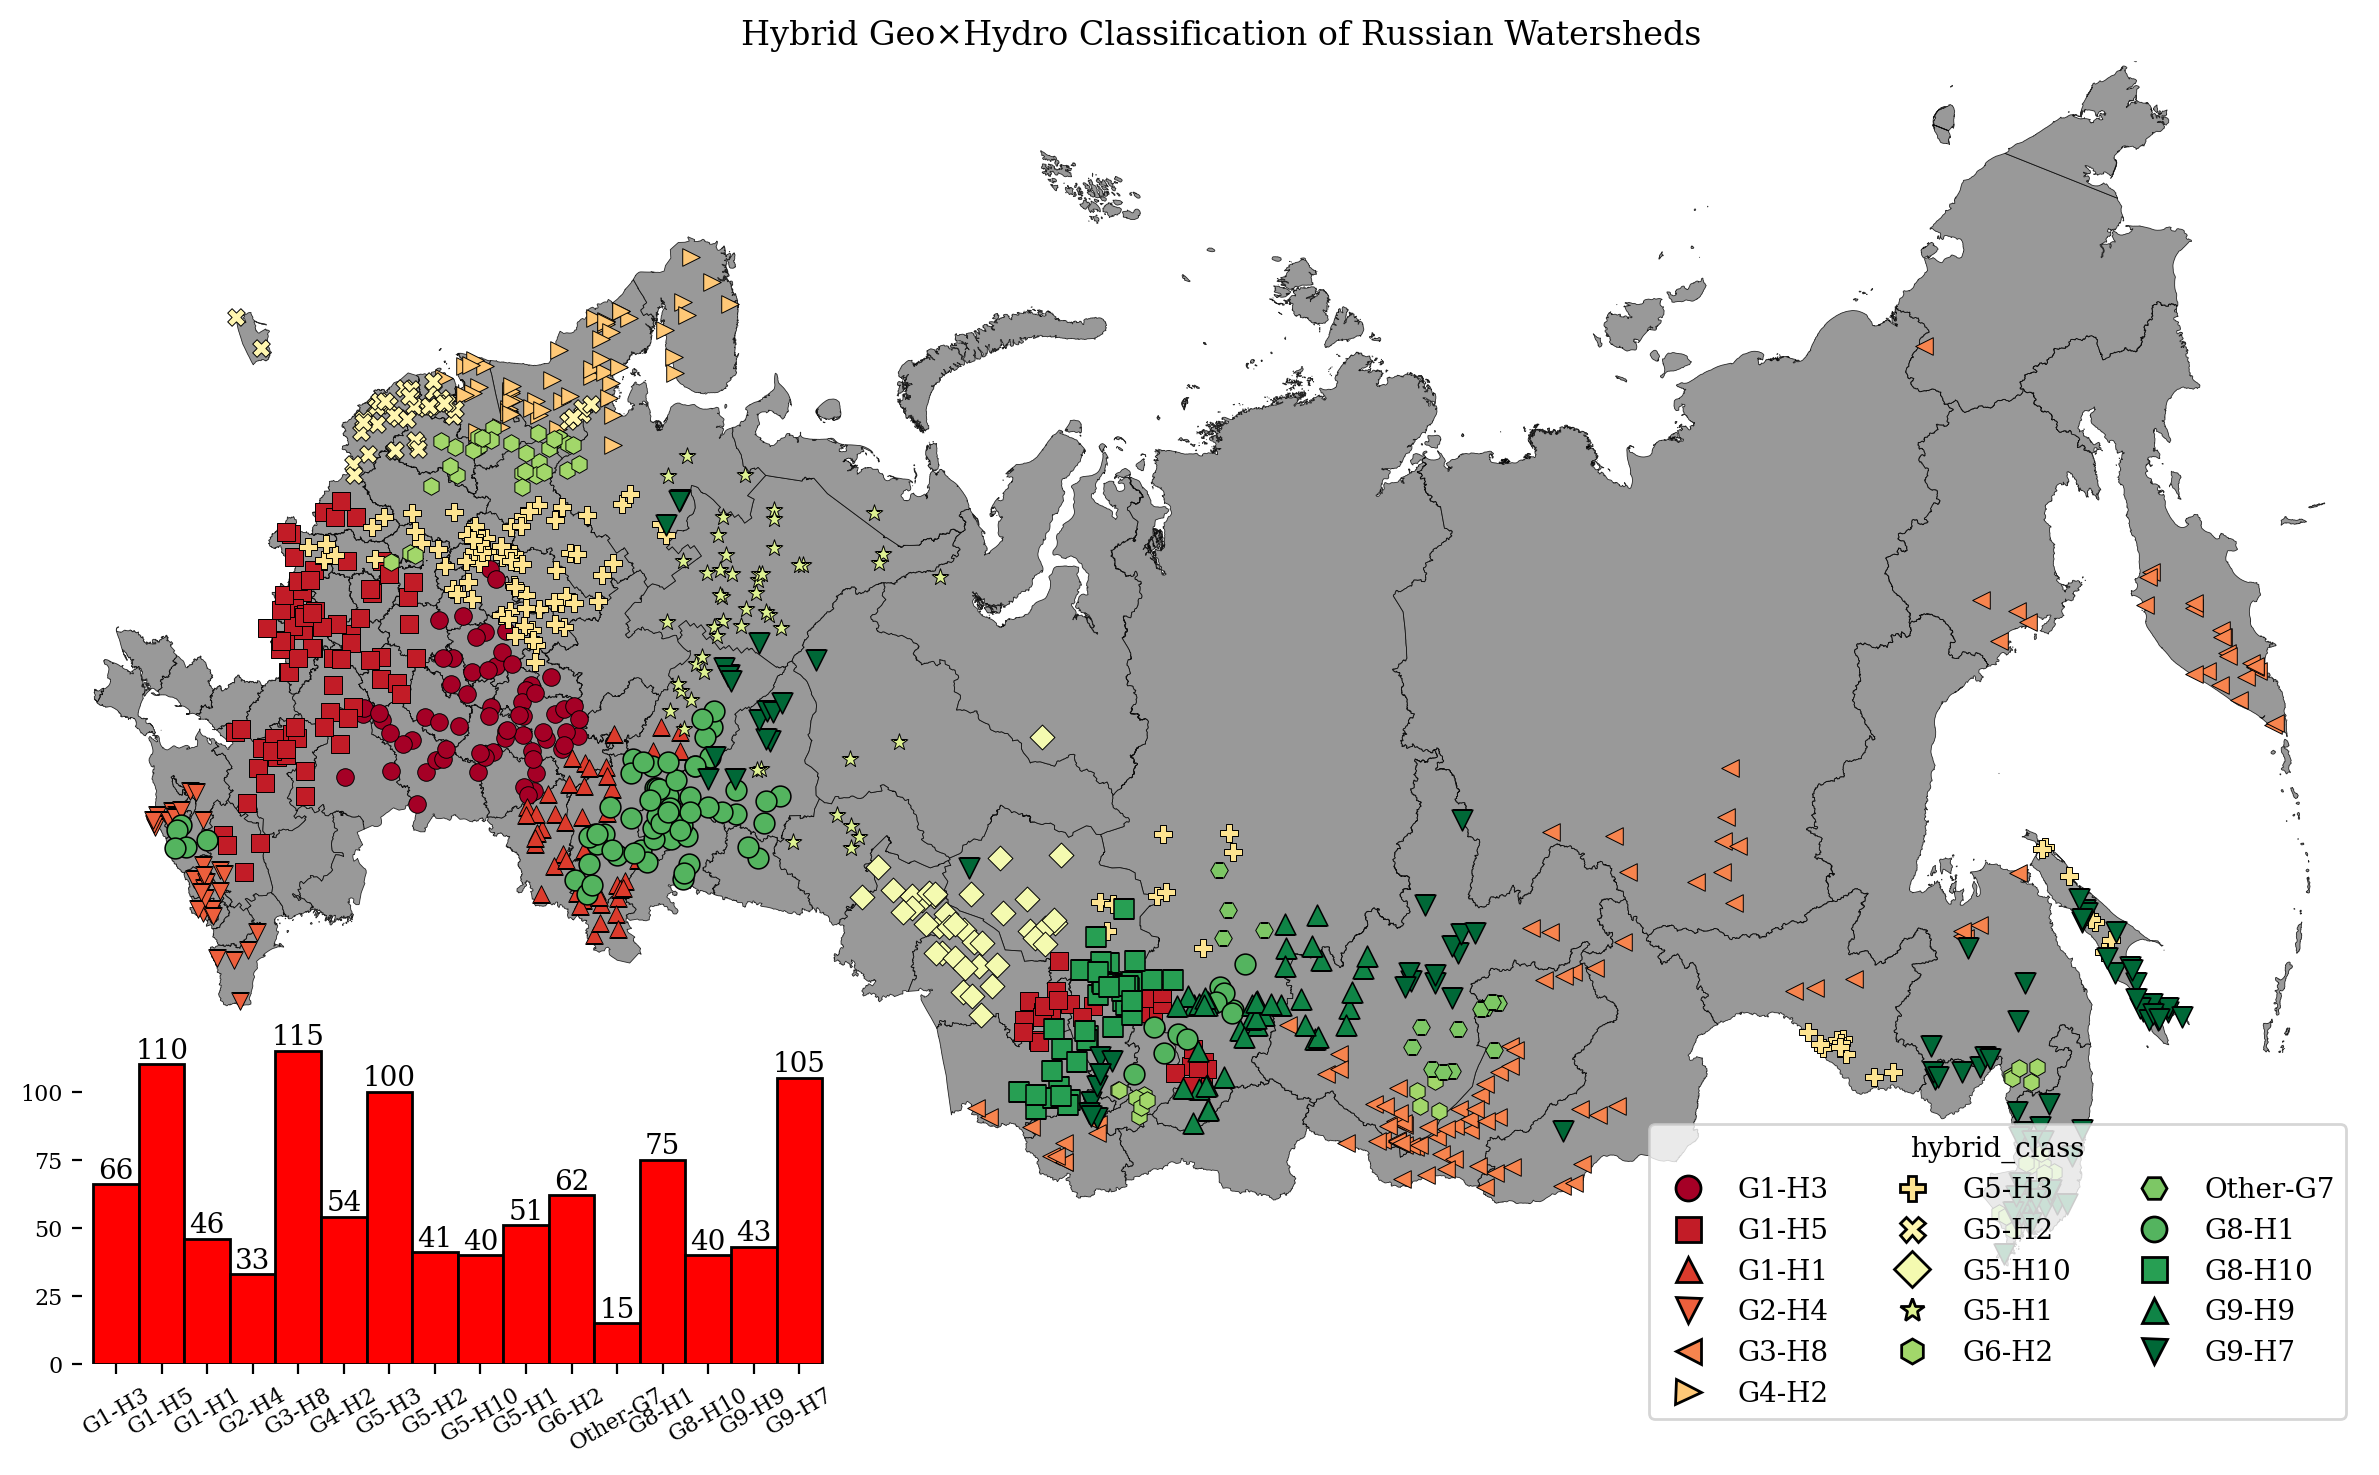

2025-11-11 00:41:32 | INFO     | PhDLogger | chapter_one | ℹ️  Saved hybrid class map to ../res/chapter_one/hybrid_analysis/images/hybrid_class_map.png


In [55]:
from src.plots.maps import russia_plots

# Plot hybrid classes on map
fig_hybrid = russia_plots(
    gdf_to_plot=gauge_clustered,
    basemap_data=basemap_data,
    distinction_col="hybrid_class",
    just_points=True,
    legend_cols=3,
    with_histogram=True,
    title_text="Hybrid Geo×Hydro Classification of Russian Watersheds",
    figsize=(12, 8),
    base_marker_size=40,
)

plt.tight_layout()
plt.savefig(img_dir / "hybrid_class_map.png", dpi=300, bbox_inches="tight")
plt.show()

log.info(f"Saved hybrid class map to {img_dir / 'hybrid_class_map.png'}")

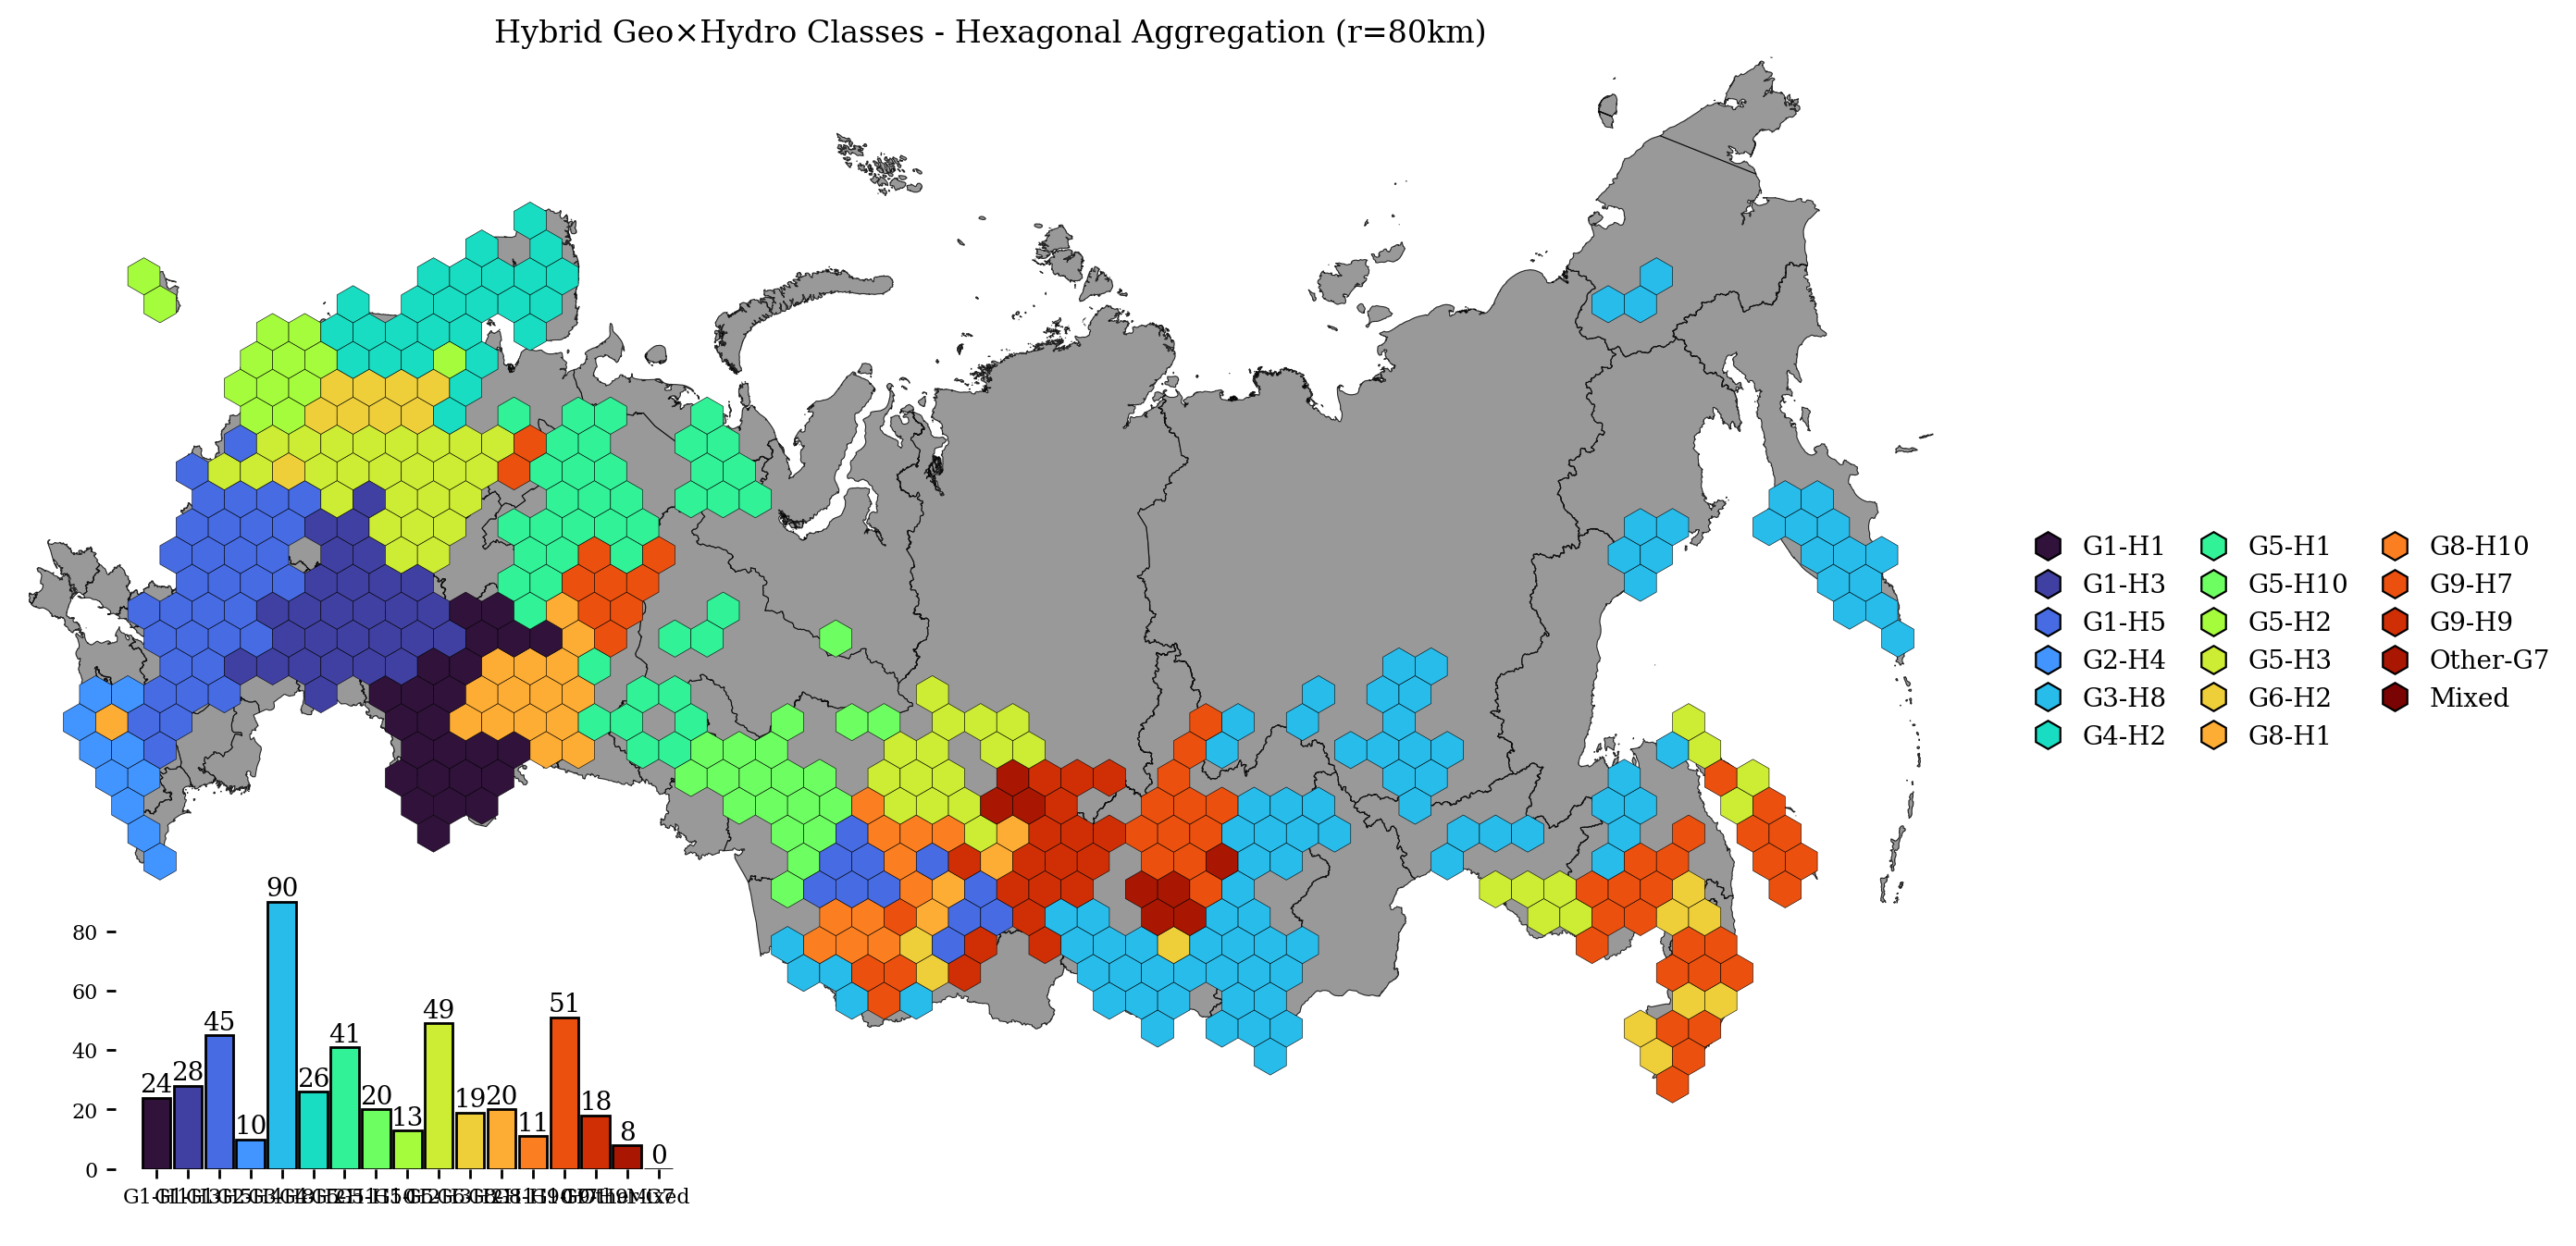

2025-11-11 00:41:43 | INFO     | PhDLogger | chapter_one | ℹ️  Saved hexagonal distribution map to ../res/chapter_one/hybrid_analysis/images/hybrid_hex_distribution.png


In [56]:
from src.plots.hex_maps import hex_model_distribution_plot

# Create mapping dictionary for hybrid classes
hybrid_class_list = sorted(gauges_final["hybrid_class"].dropna().unique())
hybrid_dict = {cls: idx for idx, cls in enumerate(hybrid_class_list)}

# Prepare watersheds with hybrid class
ws_with_class = ws.copy()
ws_with_class["hybrid_class"] = gauge_clustered.loc[ws.index, "hybrid_class"]

# Plot hexagonal distribution
fig_hex, ax_hex, hex_result, class_counts = hex_model_distribution_plot(
    watersheds=ws_with_class,
    basemap_data=basemap_data,
    model_col="hybrid_class",
    model_dict=hybrid_dict,
    r_km=80,
    min_overlap_share=0.15,
    dominant_threshold=0.33,
    ambiguous_label="Mixed",
    figsize=(14, 8),
    legend=True,
    legend_columns=3,
    histogram=True,
    title="Hybrid Geo×Hydro Classes - Hexagonal Aggregation (r=80km)",
)

plt.tight_layout()
plt.savefig(img_dir / "hybrid_hex_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

log.info(f"Saved hexagonal distribution map to {img_dir / 'hybrid_hex_distribution.png'}")

In [ ]:
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Prepare feature matrix for validation (combine geo + hydro features)
# Geographic features (normalized)
X_geo = geo_scaled.loc[common_index].values

# Hydrological features (normalized seasonal patterns)
X_hydro = q_df_normalized.T.loc[common_index].values

# Combine features (weighted equally)
X_combined = np.hstack([X_geo, X_hydro])

# Get hybrid class labels (convert to numeric)
hybrid_labels = gauges_final_wgs84.loc[common_index, "hybrid_class"]
label_encoder = {cls: idx for idx, cls in enumerate(hybrid_labels.unique())}
y_hybrid = hybrid_labels.map(label_encoder).values

# Calculate cluster validity indices
silhouette_hybrid = silhouette_score(X_combined, y_hybrid, metric="euclidean")
db_index_hybrid = davies_bouldin_score(X_combined, y_hybrid)

print("=== Hybrid Clustering Validation Metrics ===")
print(f"Silhouette Score: {silhouette_hybrid:.3f} (higher is better, range [-1, 1])")
print(f"Davies-Bouldin Index: {db_index_hybrid:.3f} (lower is better)")
print(f"\nNumber of final classes: {len(label_encoder)}")
print(f"Mean gauges per class: {len(common_index) / len(label_encoder):.1f}")

# Compare with individual clustering approaches
silhouette_geo = silhouette_score(X_geo, geo_labels, metric="euclidean")
silhouette_hydro = silhouette_score(X_hydro, hydro_labels, metric="euclidean")

print("\n=== Comparison with Single-Domain Clustering ===")
print(f"Geo-only Silhouette: {silhouette_geo:.3f}")
print(f"Hydro-only Silhouette: {silhouette_hydro:.3f}")
print(f"Hybrid Silhouette: {silhouette_hybrid:.3f}")

# Create summary table
summary_stats = pd.DataFrame(
    {
        "Approach": ["Geographic Only", "Hydrological Only", "Hybrid Geo×Hydro"],
        "N_Clusters": [cluster_number, n_hydro_clusters, len(label_encoder)],
        "Silhouette": [silhouette_geo, silhouette_hydro, silhouette_hybrid],
        "Davies_Bouldin": [
            davies_bouldin_score(X_geo, geo_labels),
            davies_bouldin_score(X_hydro, hydro_labels),
            db_index_hybrid,
        ],
    }
)

print("\n=== Summary Statistics ===")
print(summary_stats.to_string(index=False))

# Save summary
summary_stats.to_csv(table_dir / "clustering_validation_summary.csv", index=False)
log.info(f"Saved validation summary to {table_dir / 'clustering_validation_summary.csv'}")